# Libraries

Notebook Color Scheme:


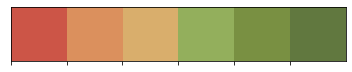

In [1]:
# Libraries
import os
import gc
import wandb
import time
import random
import shutil
import math
import glob
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html

class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'
my_colors = ["#CC5547", "#DB905D", "#D9AE6C", "#93AF5C", "#799042", "#61783F"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [2]:
# Functions to get image width and height
def get_img_size(x, flag):
    
    if x != 0:
        split = x.split("_")
        width = split[3]
        height = split[4]
    
        if flag == "width":
            return int(width)
        elif flag == "height":
            return int(height)
    
    return 0


def get_pixel_size(x, flag):
    
    if x != 0:
        split = x.split("_")
        width = split[-2]
        height = ".".join(split[-1].split(".")[:-1])
    
        if flag == "width":
            return float(width)
        elif flag == "height":
            return float(height)
    
    return 0

# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

In [3]:
# --- Custom Color Maps ---
# Yellow Purple Red
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

# 1. Train Data
 
I am looking first at the `train.csv` dataset, as to get familiar with what are we actually working with. I am also starting a new experiment that will be linked to this entire section of analysis.

### To Remember**:
* The `train.csv` has 115,488 total rows and 3 columns
* There are 38,96 unique `ids` - or cases
* Each unique `id` appears within the dataset 3 times, depending on the `class` of the image (`large_bowel`, `small_bowel`, `stomach`)
* the `class` should be treated like a **flag** that shows WHERE is the healthy organs are actually located within one image
* The `segmentation` category flags precisely (not with bounding box, but using pixels) the organs - if nothing is found in neither classes, it will be marked as `None` (or missing)

In [4]:
print(clr.S+"--- train.csv ---"+clr.E)
train = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")

print(clr.S+"shape:"+clr.E, train.shape)
print(clr.S+"Unique ID cases:"+clr.E, train["id"].nunique())
print(clr.S+"Missing Values Column:"+clr.E, train.isna().sum().index[-1])
print("\t", clr.S+"with a total missing rows of:"+clr.E, train.isna().sum().values[-1])
print("\t", clr.S+"% of missing rows:"+clr.E, 
      len(train[train["segmentation"].isna()==False]), "\n")

print(clr.S+"Sample of train.csv:"+clr.E)
train.sample(5, random_state=26)

--- train.csv ---
shape: (115488, 3)
Unique ID cases: 38496
Missing Values Column: segmentation
	 with a total missing rows of: 81575
	 % of missing rows: 33913 

Sample of train.csv:


id        class  \
77704  case141_day27_slice_0046  small_bowel   
32988   case134_day0_slice_0085  large_bowel   
6379   case139_day18_slice_0111  small_bowel   
63212   case11_day13_slice_0079      stomach   
59989    case33_day0_slice_0013  small_bowel   

                                            segmentation  
77704                                                NaN  
32988  41591 5 41599 7 41949 27 42308 37 42667 40 430...  
6379                                                 NaN  
63212                                                NaN  
59989                                                NaN

In [5]:
def get_image_path(base_path, df):
    '''Gets the case, day, slice_no and path of the dataset (either train or test).
    base_path: path to train image folder
    return :: modified dataframe'''
    
    # Create case, day and slice columns
    df["case"] = df["id"].apply(lambda x: x.split("_")[0])
    df["day"] = df["id"].apply(lambda x: x.split("_")[1])
    df["slice_no"] = df["id"].apply(lambda x: x.split("_")[-1])

    df["path"] = 0
    
    n = len(df)

    # Loop through entire dataset
    for k in tqdm(range(n)):
        data = df.iloc[k, :]
        segmentation = data.segmentation

        # In case coordinates for healthy tissue are present
        if pd.isnull(train.iloc[k, 2]) == False:
            case = data.case
            day = data.day
            slice_no = data.slice_no
            # Change value to the correct one
            df.loc[k, "path"] = glob.glob(f"{base_path}/{case}/{case}_{day}/scans/slice_{slice_no}*")[0]
            
    return df

In [6]:
# BASE path (for train)
base_path = "../input/uw-madison-gi-tract-image-segmentation/train"

# Prep and save file
train = get_image_path(base_path, df=train)

print(clr.S+"train.csv now:"+clr.E)
train.head(3)

100%|██████████| 115488/115488 [02:24<00:00, 801.95it/s] 

train.csv now:


id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   

  slice_no path  
0     0001    0  
1     0001    0  
2     0001    0

### - Cases, Day, Slice No. -

So after I have splitted the `id` into multiple categories:
* case number
* day - the day the picture was registered
* and slice number

... then I can easily plot the distribution (or barplot, as these are categorical values) to see some more information from the data.

### - Frequency between Days -

**Average Day per Case**:
* Most of the cases were taken on average between day10 and day20
* There are also many cases took in day0 and day1

**Total Days/Case**:
* The total number of unique days per case varies between 1 and 6
* The majority of the cases have data taken for ~ 3 and 5 days in total.

In [7]:
# Get only case and day data
# Creating a new dataframe and extracting only the number
# from the 2 columns
case_day = pd.DataFrame({"case" : train["case"].apply(lambda x: int("".join([i for i in x if i.isdigit()]))),
                         "day" : train["day"].apply(lambda x: int("".join([i for i in x if i.isdigit()])))})

# Sepparate 2 dataframes
# one containing average days per case & the other count of days per case
day_mean = case_day.groupby("case")["day"].mean().reset_index()
day_count = case_day.groupby("case")["day"].unique().reset_index()
day_count["day"] = day_count["day"].apply(lambda x: len(x))

print(clr.S+"case_day.head():"+clr.E, "\n")
case_day.head(5)

case_day.head(): 



case  day
0   123   20
1   123   20
2   123   20
3   123   20
4   123   20

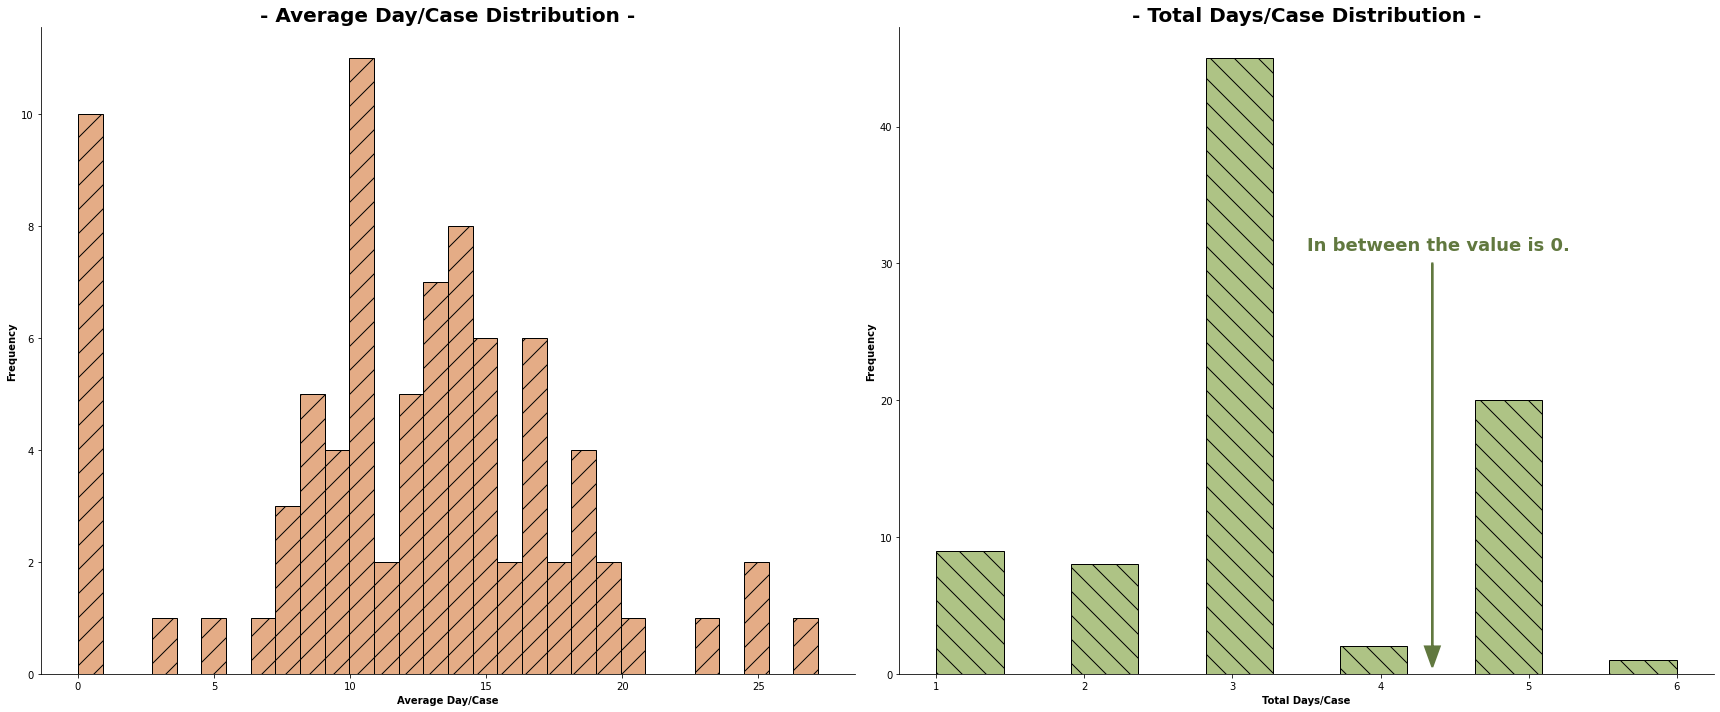

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
titles = ["Average Day/Case Distribution", "Total Days/Case Distribution"]
# hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])

sns.histplot(data=day_mean, x="day",bins=30, color=my_colors[1], ax=ax1)

sns.histplot(data=day_count, x="day", color=my_colors[3], ax=ax2)

for ax, t, label in zip([ax1, ax2], titles, ["Average Day/Case", "Total Days/Case"]):
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_xlabel(f"{label}", weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    

for i, bar in enumerate(ax1.patches):
    bar.set_hatch("/")
#     bar.set_edgecolor(my_colors[0])
    
for i, bar in enumerate(ax2.patches):
    bar.set_hatch("\\")
    
ax2.arrow(x=4.35, y=30, dx=0, dy=-28, head_width=0.1, head_length=1.5,
          color=my_colors[-1], linewidth=2)
ax2.text(x=3.5, y=31, s="In between the value is 0.", size=18, 
         color=my_colors[-1], weight="bold")
    
sns.despine()
fig.tight_layout();

### 1.3 Image/Pixel width & height

From the path we can also extract the `image` and `pixel` widths & heights and explore. From the graph below we can see that the dimensions do not vary a lot - moreover, all images are almost squared shapes.

In [9]:
# Retrieve image width and height
train["image_width"] = train["path"].apply(lambda x: get_img_size(x, "width"))
train["image_height"] = train["path"].apply(lambda x: get_img_size(x, "height"))

train["pixel_width"] = train["path"].apply(lambda x: get_pixel_size(x, "width"))
train["pixel_height"] = train["path"].apply(lambda x: get_pixel_size(x, "height"))

print(clr.S+"train.csv now:"+clr.E)
train.head(3)

train.csv now:


id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   

  slice_no path  image_width  image_height  pixel_width  pixel_height  
0     0001    0            0             0          0.0           0.0  
1     0001    0            0             0          0.0           0.0  
2     0001    0            0             0          0.0           0.0

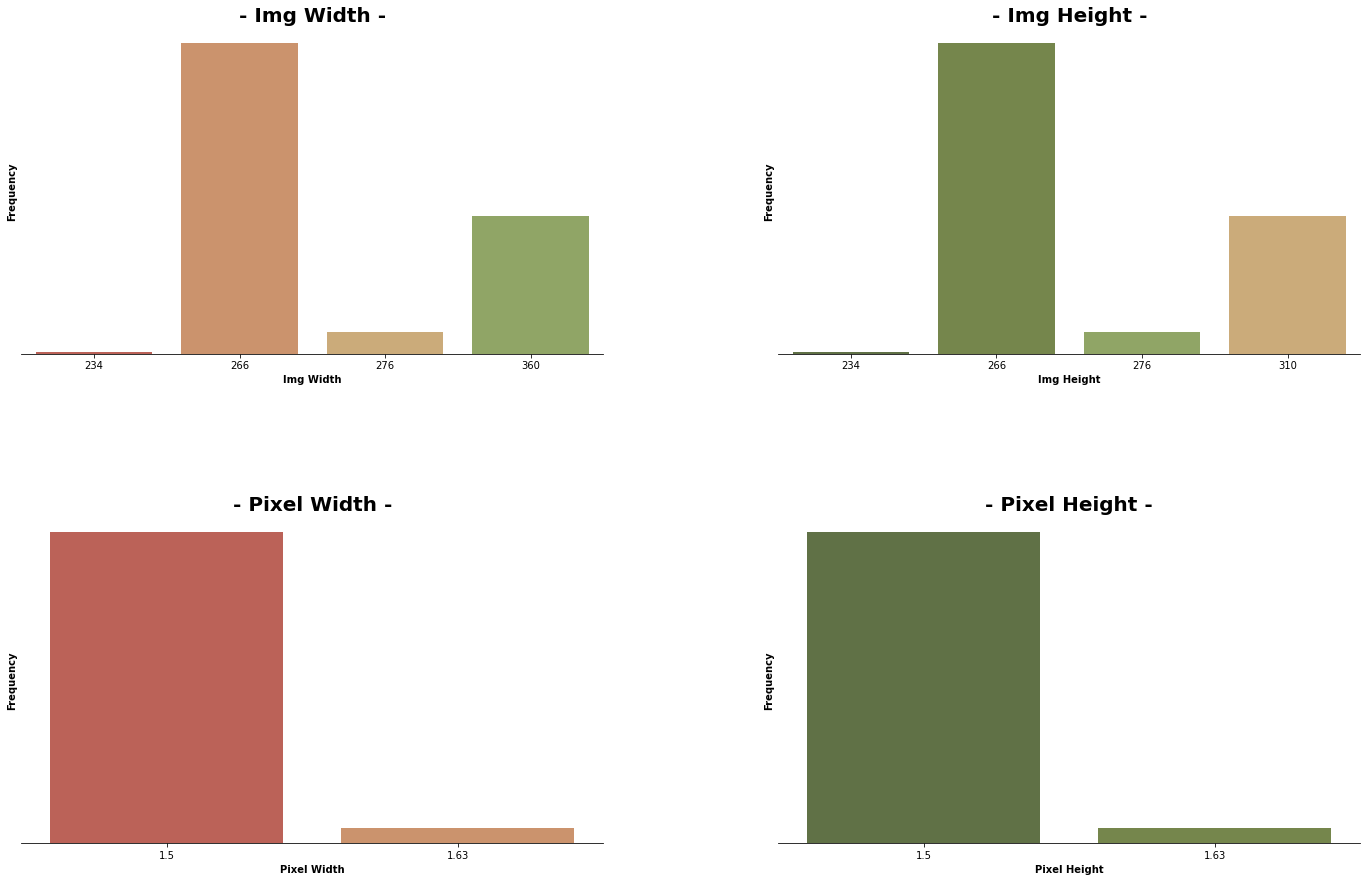

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 15))
titles = ["Img Width", "Img Height", "Pixel Width", "Pixel Height"]

dt = train[train["image_width"] != 0.0].reset_index(drop=True)

sns.barplot(data=dt["image_width"].value_counts().reset_index(),
            x="index", y="image_width", ax=ax1, 
            palette=my_colors)

sns.barplot(data=dt["image_height"].value_counts().reset_index(),
            x="index", y="image_height", ax=ax2,
            palette=my_colors[::-1])

sns.barplot(data=dt["pixel_width"].value_counts().reset_index(),
            x="index", y="pixel_width", ax=ax3, 
            palette=my_colors)

sns.barplot(data=dt["pixel_height"].value_counts().reset_index(),
            x="index", y="pixel_height", ax=ax4,
            palette=my_colors[::-1])

for ax, t in zip([ax1, ax2, ax3, ax4], titles):
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{t}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

## 1.4 Segmentation View

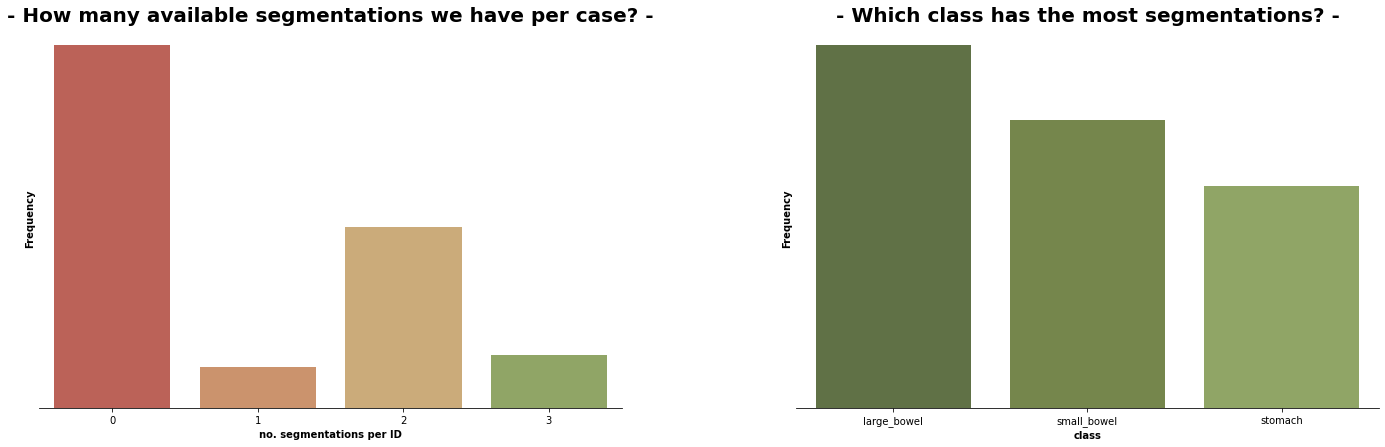

In [11]:
# Data
segment_per_id = train.groupby("id")["segmentation"].count()\
                    .reset_index()["segmentation"].value_counts().reset_index()

segment_per_class = train.groupby("class")["segmentation"].count().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
titles = ["How many available segmentations we have per case?",
          "Which class has the most segmentations?"]


sns.barplot(data=segment_per_id,
            x="index", y="segmentation", ax=ax1, 
            palette=my_colors)

sns.barplot(data=segment_per_class,
            x="class", y="segmentation", ax=ax2,
            palette=my_colors[::-1])


for ax, t, x in zip([ax1, ax2], titles, ["no. segmentations per ID", "class"]):
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{x}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

# 2. Images

Now let's explore the `.png` images and their masks.

In [12]:
def read_image(path):
    '''Reads and converts the image.
    path: the full complete path to the .png file'''

    # Read image in a corresponding manner
    # convert int16 -> float32
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    # Scale to [0, 255]
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    
    return image

In [13]:
def show_simple_images(sample_paths, image_names="sample_images"):
    '''Displays simple images (without mask).'''

    # Get additional info from the path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]


    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, 
                         color = my_colors[-1], weight='bold')

        img = read_image(path)
        wandb_images.append(wandb.Image(img))
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

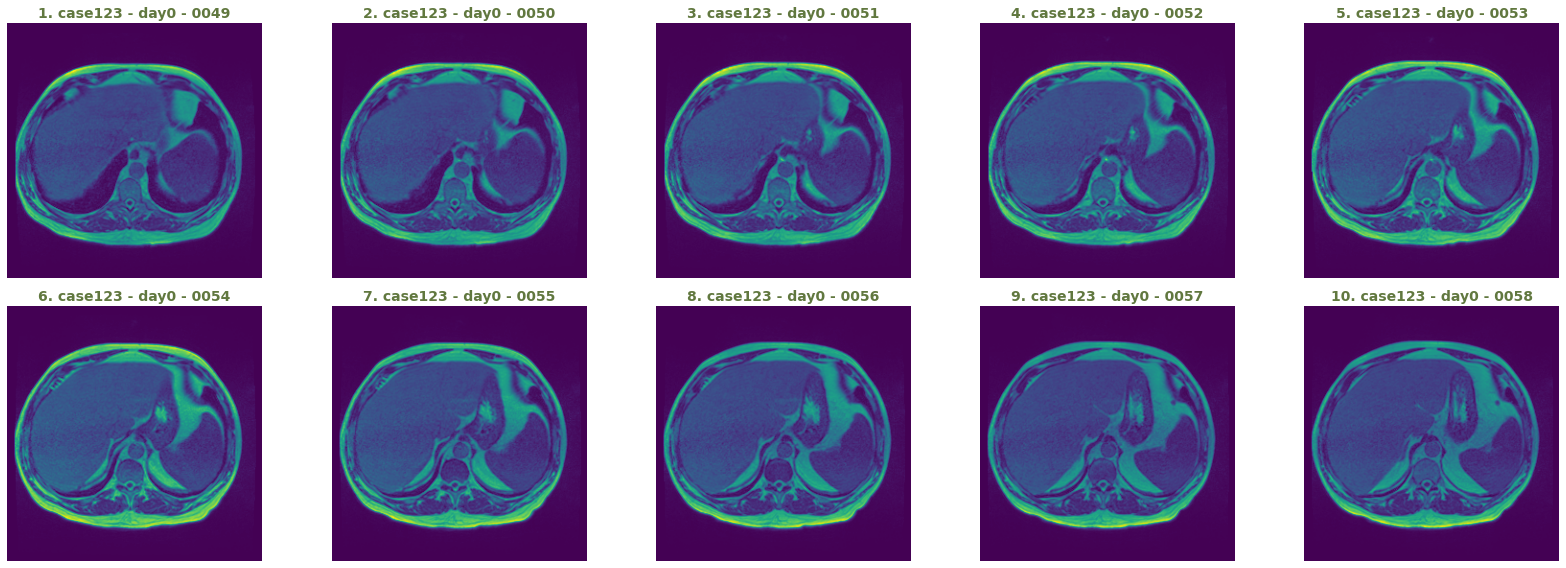

In [14]:
CASE = "case123"

# Sample a few images from speciffied case
sample_paths1 = train[(train["segmentation"].isna()==False) & (train["case"]==CASE)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths1, image_names="case123_samples")

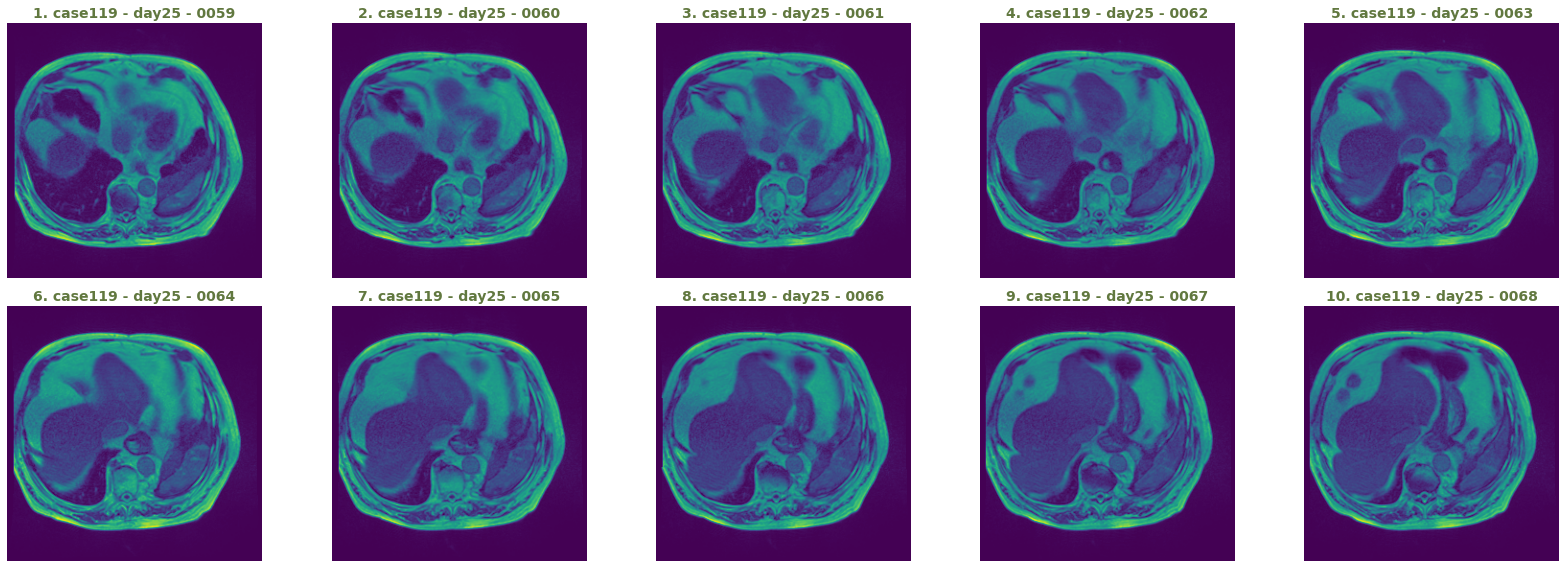

In [15]:
DAY = "day25"

# Sample a few images from speciffied case
sample_paths2 = train[(train["segmentation"].isna()==False) & (train["day"]==DAY)]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths2, image_names="day25_samples")

## 2.2 Create the masks

 A case (or `id`) can have the following possibilities**:
1. **ALL** `small_bowel`, `large_bowel` and `stomach` have **NO** segmentation
2. **SOME** of the `small_bowel`, `large_bowel` and `stomach` have **SOME** segmentation
3. **ALL** `small_bowel`, `large_bowel` and `stomach` **DO HAVE** segmentation

### I. From Segmentation to Mask

In [16]:
def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

### II. Get full Mask for each ID

Now, for each ID, we are going to create an image of shape `[img height, img width, 3]`, where 3 (number of channels) are the 3 layers for each class:
* **the first layer**: large bowel
* **the second layer**: small bowel
* **the third layer**: stomach

Hence, these masks will accompany the original images and, alongside them will provide valuable information on the evolution of healthy tissue in each slice:
<center><img src="https://i.imgur.com/DyLBCfL.png" width=700></center>

In [17]:
def get_id_mask(ID, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data.loc[k, :] for k in range(3)]


    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = np.max([obs.image_height for obs in observations])
    max_width = np.max([obs.image_width for obs in observations])

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = observations[k]
            segmentation = observation.segmentation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

    # If no segmentation was found skip
    elif max_segmentation == 0:
        mask = None
        if verbose:
            print("None of the classes have segmentation.")
            
    return mask

In [18]:
# Full Example

# Read image
path = '../input/uw-madison-gi-tract-image-segmentation/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = read_image(path)

# Get mask
ID = "case131_day0_slice_0066"
mask = get_id_mask(ID, verbose=False)

** Plotting an Example:**
1. we change the pixels of the `mask`: when 0 then switch to `NA` (transparent), when 1 we mark as `True`
2. we split the channels of the `mask`: each mask has 3 channels, one for each `class`
3. plot the original image
4. plot over this image the 3 channel layers (or classes)

In [19]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()

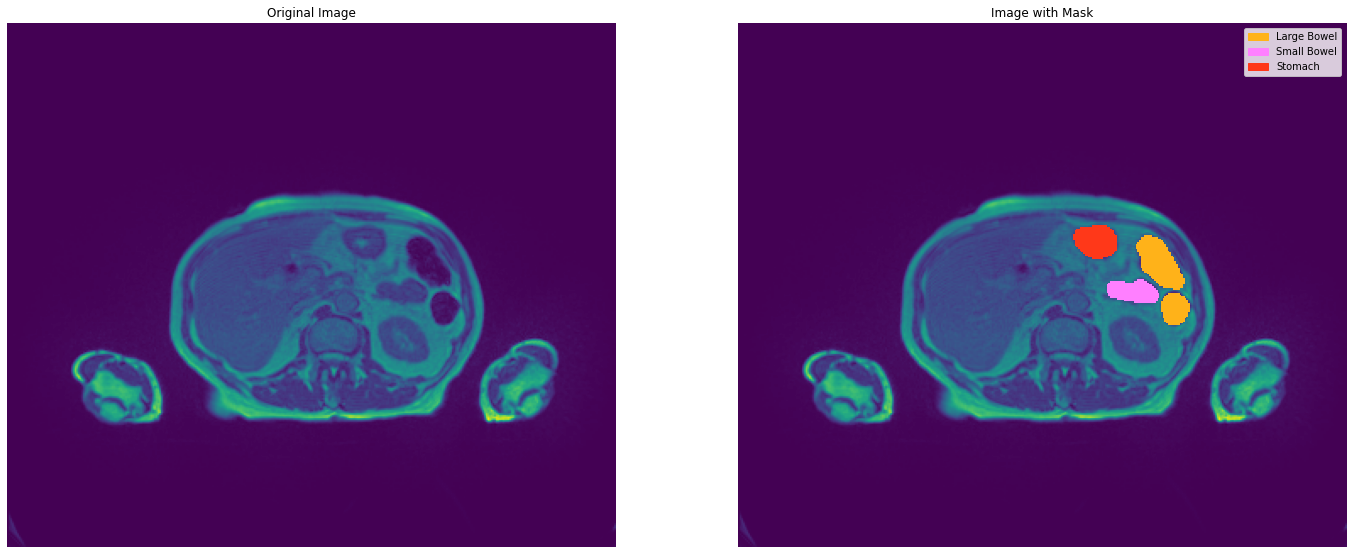

In [20]:
plot_original_mask(img, mask, alpha=1)

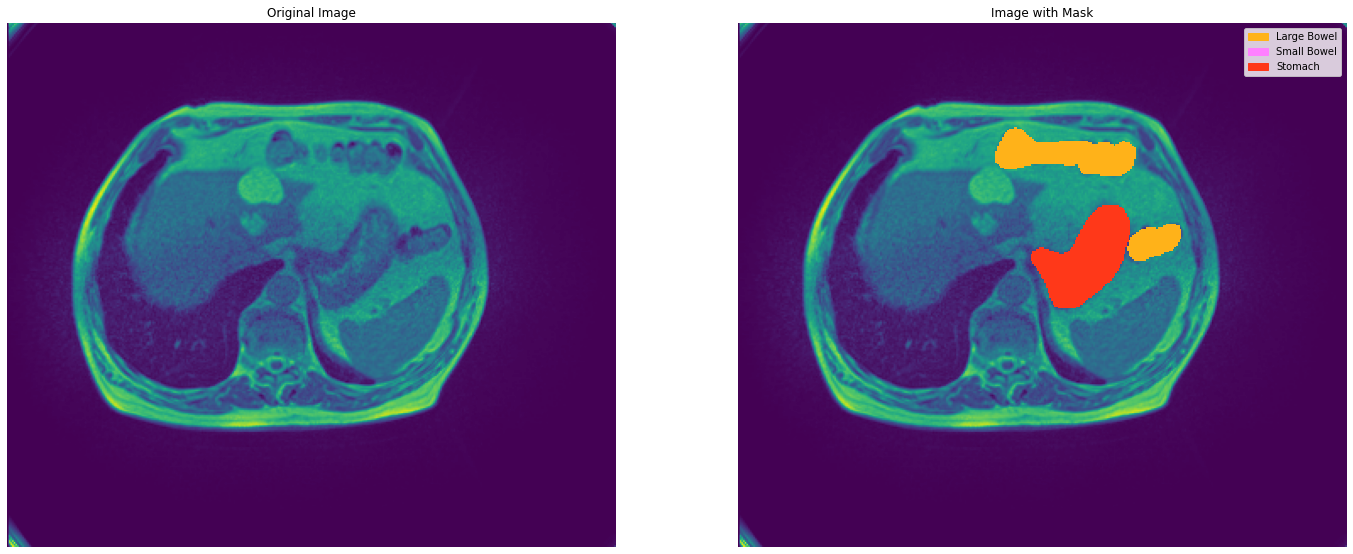

In [21]:
# Another example
path = '../input/uw-madison-gi-tract-image-segmentation/train/case18/case18_day0/scans/slice_0069_360_310_1.50_1.50.png'
img = read_image(path)

ID = "case18_day0_slice_0069"
mask = get_id_mask(ID, verbose=False)

plot_original_mask(img, mask, alpha=1)

## 2.3 Explore the masks

Let's now explore the masks on images and observe their **evolution**, how they move and react for each slice.

In [22]:
# Filter out all instances with no segmentation
data = train[train["segmentation"].isna()==False].reset_index(drop=True)

#### ⬇ Function below to plot multiple images & masks in chronologic order

In [23]:
def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

**Case 123 | Day 20 | Slices 0085 -> 0094**
* the *stomach* segmentation decreases by each slice
* the *small bowel* segmentation increases in size and doubles on the left side of the CT too
* the *large bowel* seems to be decreasing by each slice until it splits in 2 smaller portions

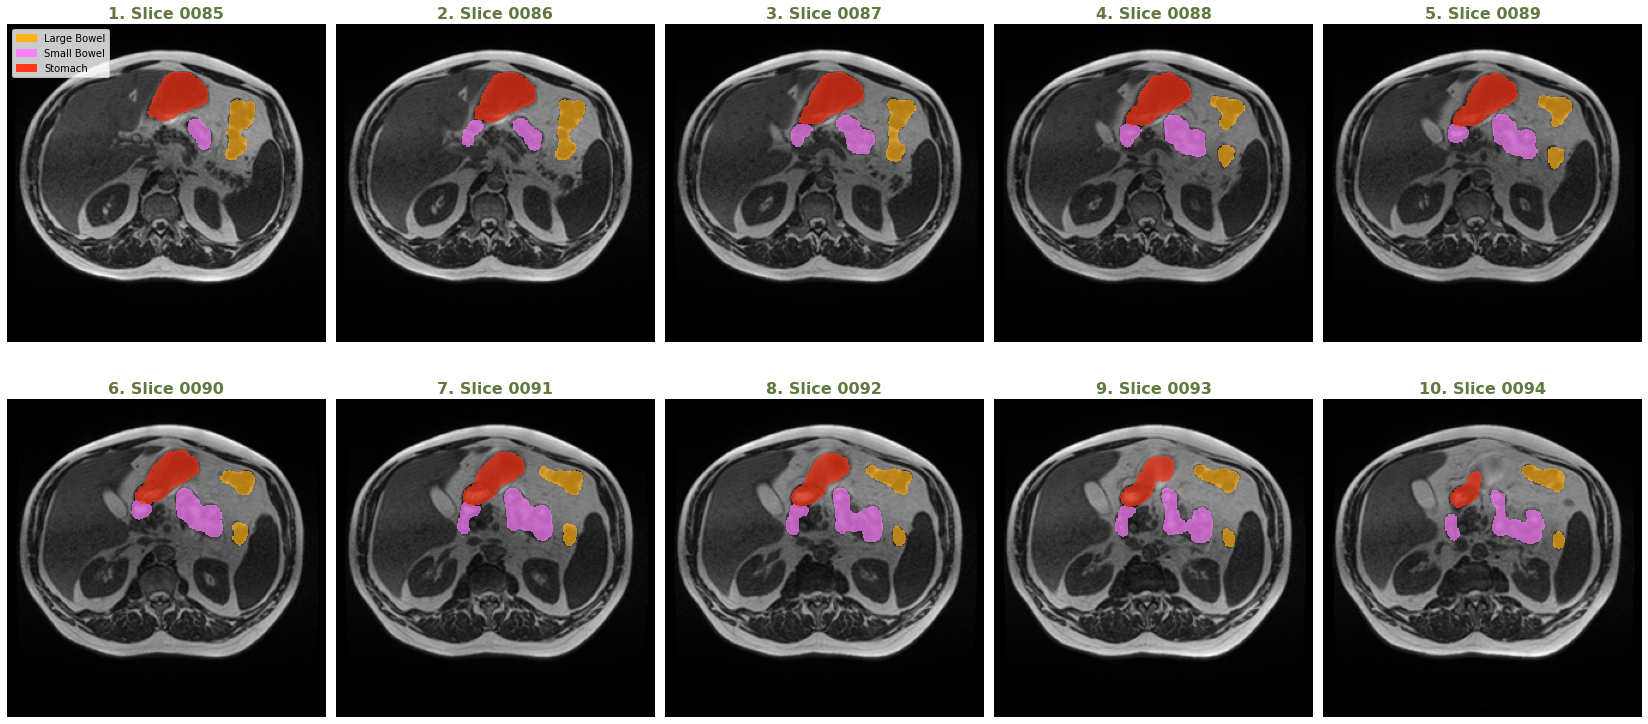

In [24]:
# Get random case
case = "case123"
day="day20"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 30 | Day 0 | Slices 0092 -> 0101**
* the *stomach* segmentation appears in the second slice and starts increasing in size
* the *small bowel* segmentation is not present at all
* the *large bowel* increases in size too

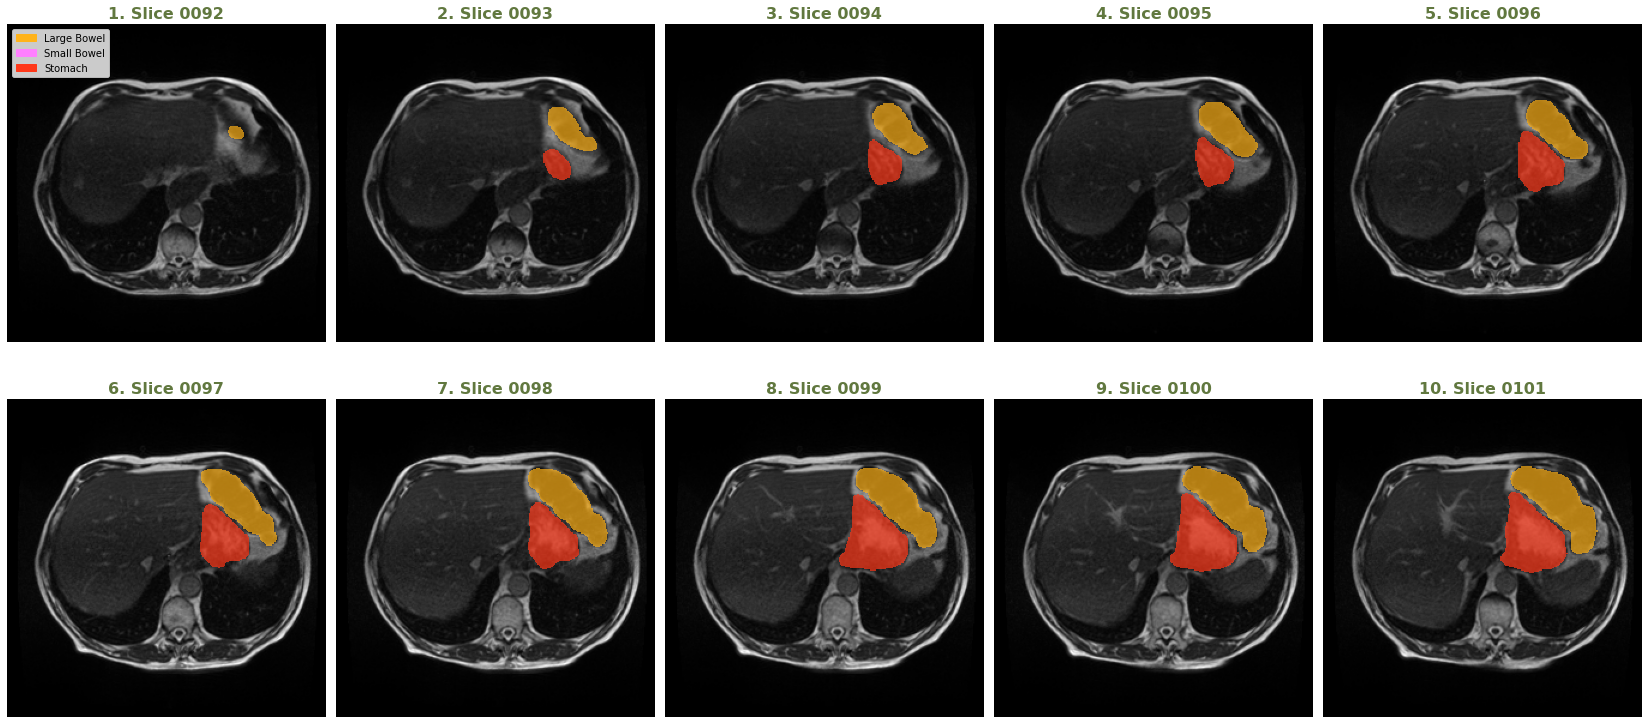

In [25]:
# Get random case
case = "case30"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 18 | Day 0 | Slices 0060 -> 0069**
* the *stomach* segmentation increases by each slice
* the *small bowel* is not present in any of the slices
* the *large bowel* increases in size too and duplicates at some point next to the stomach too

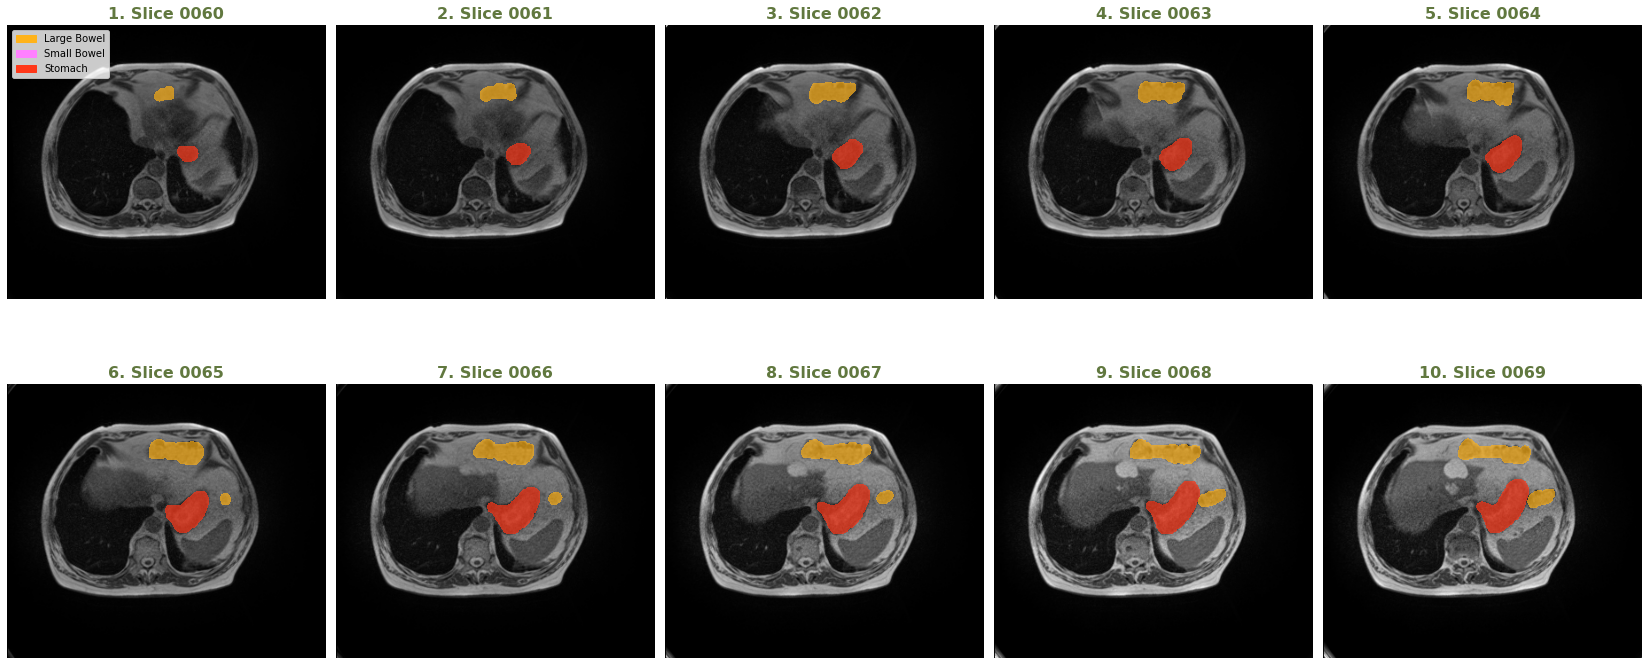

In [26]:
# Get random case
case = "case18"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

**Case 146 | Day 0 | Slices 0080 -> 0089**
* the *stomach* segmentation is not present in any of the slices
* the *small bowel* segmentation has 2 locations and increases and splits in size by each slice (the last slice has 5 distinct locations where the healthy tissue is present)
* the *large bowel* increases in size, at some point 2 portions even unite in only one singural bigger piece

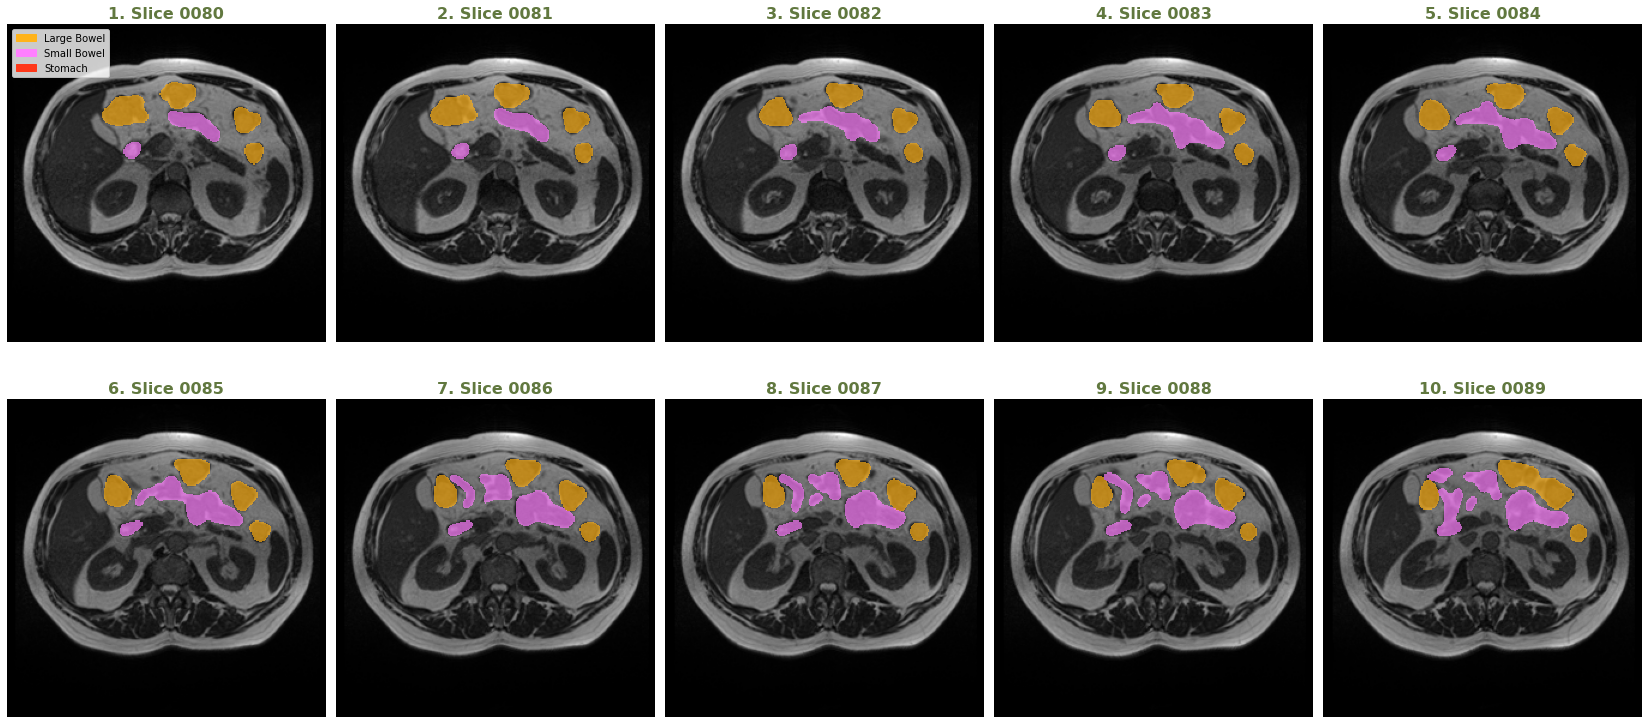

In [27]:
# Get random case
case = "case146"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)